# Shakeout the Milvus connectivity


In [1]:
# Step 1: Install necessary libraries (run in a cell if needed)
!pip install -r requirements.txt

from pymilvus import connections, Collection, CollectionSchema, FieldSchema, DataType
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 244.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 166.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 416.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 252.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 256.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

/opt/app-root/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Step 2: Connect to Milvus
connections.connect(alias="default", host="milvus-service.milvus.svc.cluster.local", port="19530")

In [3]:
# Step 3: Define collection
fields = [
    FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=False),
    FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=384)
]
schema = CollectionSchema(fields, description="Simple semantic vector test")
collection_name = "animal_test"
collection = Collection(name=collection_name, schema=schema)

In [4]:
# Step 4: Generate embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
terms = ["dog", "cat", "pumpkin"]
embeddings = model.encode(terms)

# Display the first 5 rows of embedding data
for term, vector in zip(terms, embeddings):
    print(f"Embedding for '{term}' (first 5 values):\n{vector[:5]}\n")

Embedding for 'dog' (first 5 values):
[-0.05314701  0.0141944   0.00714575  0.06860869 -0.07848033]

Embedding for 'cat' (first 5 values):
[ 0.03733039  0.05116175 -0.00030608  0.06020985 -0.11749439]

Embedding for 'pumpkin' (first 5 values):
[ 0.00623482  0.02070914 -0.05396153  0.05416822 -0.01124371]



In [5]:
# Step 5: Insert into Milvus
data = [
    [0, 1, 2],  # ids
    embeddings.tolist()
]
collection.insert(data)

# Create index on the vector field
collection.create_index(
    field_name="embedding",
    index_params={
        "metric_type": "COSINE",
        "index_type": "IVF_FLAT",
        "params": {"nlist": 128}
    }
)

collection.load()

In [6]:
# Step 6: Perform search
def search(term):
    vector = model.encode([term])
    results = collection.search(vector, "embedding", param={"metric_type": "COSINE"}, limit=3)
    return results

results_dog = search("dog")

In [7]:
# Step 7: Cosine similarity for illustration
cos_sim = cosine_similarity([embeddings[0]], embeddings[1:])
print("Similarity (dog vs cat):", cos_sim[0][0])
print("Similarity (dog vs pumpkin):", cos_sim[0][1])

Similarity (dog vs cat): 0.6606375
Similarity (dog vs pumpkin): 0.37011895


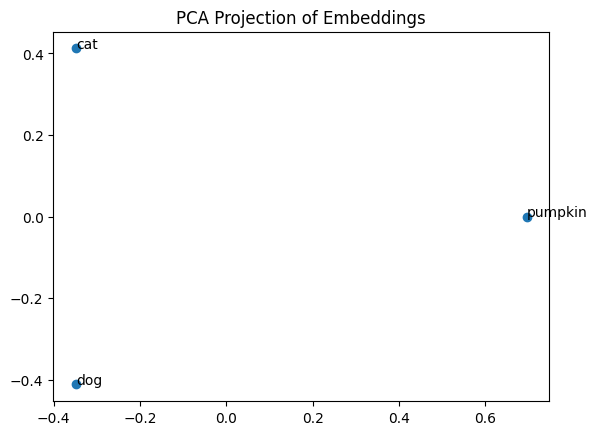

In [8]:
# Step 8: Optional visualisation
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)
plt.scatter(reduced[:, 0], reduced[:, 1])
for i, term in enumerate(terms):
    plt.annotate(term, (reduced[i, 0], reduced[i, 1]))
plt.title("PCA Projection of Embeddings")
plt.show()

# Shakeout minio connection

In [9]:
#!/usr/bin/env python3
"""
Shake-out test for a MinIO deployment on Kubernetes.

Environment variables:
  AWS_S3_ENDPOINT        – MinIO service DNS name (e.g. minio.minio.svc.cluster.local)
  AWS_ACCESS_KEY_ID      – MinIO access key
  AWS_SECRET_ACCESS_KEY  – MinIO secret key
  AWS_DEFAULT_REGION     – Dummy value; boto3 still expects one
"""
import os
import sys

import boto3
from botocore.client import Config
from botocore.exceptions import BotoCoreError, ClientError


def main() -> None:
    endpoint = os.getenv("AWS_S3_ENDPOINT", "minio.minio.svc.cluster.local")
    access_key = os.getenv("AWS_ACCESS_KEY_ID", "minio")
    secret_key = os.getenv("AWS_SECRET_ACCESS_KEY", "test")
    region = os.getenv("AWS_DEFAULT_REGION", "us-east-1") or "us-east-1"

    try:
        s3 = boto3.client(
            "s3",
            endpoint_url=f"http://{endpoint}",
            aws_access_key_id=access_key,
            aws_secret_access_key=secret_key,
            region_name=region,
            config=Config(signature_version="s3v4"),
        )

        resp = s3.list_buckets()
        buckets = [b["Name"] for b in resp.get("Buckets", [])]

        if buckets:
            print("🟢 Connection succeeded – buckets discovered:")
            for name in buckets:
                print(f"  • {name}")
        else:
            print("🟢 Connected but no buckets found.")

    except (BotoCoreError, ClientError) as exc:
        print(f"🔴 MinIO connectivity test failed: {exc}", file=sys.stderr)
        sys.exit(1)


if __name__ == "__main__":
    main()


🟢 Connection succeeded – buckets discovered:
  • data
  • models
  • rag-docs
